In [115]:
import os
import pandas as pd
import numpy as np
import talib
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

pd.set_option('display.max_columns', None) 

In [116]:
# データの読み込み
def load_data(file_names):
    dfs = []
    for file_name in file_names:
        df = pd.read_csv(file_name)
        dfs.append(df)
    return dfs

In [274]:
# 特徴量エンジニアリング
def feature_engineering(df, prefix):
    open = df[f'{prefix}_open'].values
    high = df[f'{prefix}_high'].values
    low = df[f'{prefix}_low'].values
    close = df[f'{prefix}_close'].values
    volume = df[f'{prefix}_volume'].values
    hilo = (high + low) / 2

    # TA-Libを使用して一般的なテクニカル指標を計算
    df[f'{prefix}_RSI'] = talib.RSI(close)/close
    df[f'{prefix}_MACD'], _, _ = talib.MACD(close)/close
    df[f'{prefix}_ATR'] = talib.ATR(high, low, close)
    df[f'{prefix}_ADX'] = talib.ADX(high, low, close)
    df[f'{prefix}_SMA'] = talib.SMA(close)
    df[f'{prefix}_EMA'] = talib.EMA(close, timeperiod=30)
    df[f'{prefix}_BB_UPPER'], df[f'{prefix}_BB_MIDDLE'], df[f'{prefix}_BB_LOWER'] = talib.BBANDS(close)
    df[f'{prefix}_BBANDS_upperband'] = (df[f'{prefix}_BB_UPPER'] - hilo) / close
    df[f'{prefix}_BBANDS_middleband'] = (df[f'{prefix}_BB_MIDDLE'] - hilo) / close
    df[f'{prefix}_BBANDS_lowerband'] = (df[f'{prefix}_BB_LOWER'] - hilo) / close
    
    df[f'{prefix}_STOCH_K'], df[f'{prefix}_STOCH_D'] = talib.STOCH(high, low, close)/close
    df[f'{prefix}_AD'] = talib.AD(high, low, close, volume)
    df[f'{prefix}_MON'] = talib.MOM(close, timeperiod=5)
    df[f'{prefix}_RCI9'] = RCI(df, prefix, period=9)
    df[f'{prefix}_RCI26'] = RCI(df, prefix, period=26)
    df[f'{prefix}_RCI52'] = RCI(df, prefix, period=52)

    # 欠損値の削除
    df = df.dropna()
    df = df.reset_index(drop=True)

    return df

# 結合のデータフレームに特徴量を追加
def add_features(df):
    df.set_index('15m_timestamp', inplace=True)
    df.index = pd.to_datetime(df.index)
    df['weekday'] = df.index.weekday
    df['month'] = df.index.month
    df['year'] = df.index.year
    
    return df

def RCI(df, prefix, period=9):
    def rank(series):
        temp = series.argsort()
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(len(series))
        return len(series) - ranks

    def calculate_rci(prices, period):
        r = np.sum((rank(prices) - rank(np.roll(prices, period))) ** 2)
        return 1 - 6 * r / (period * (period ** 2 - 1))

    return df[f'{prefix}_close'].rolling(window=period).apply(calculate_rci, args=(period,), raw=True)

In [275]:
# ラベルデータ作成
def create_label(df, prefix, lookahead=1):
    df[f'{prefix}_target'] = (df[f'{prefix}_close'].shift(-lookahead) > df[f'{prefix}_close']).astype(int)
    df = df.dropna()
    return df

In [276]:
# 学習曲線のグラフを表示する関数
def plot_learning_curve(evals_result):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(np.arange(len(evals_result['training']['binary_logloss'])),
            evals_result['training']['binary_logloss'], label='Training')
    ax.plot(np.arange(len(evals_result['valid_1']['binary_logloss'])),
            evals_result['valid_1']['binary_logloss'], label='Validation')
    ax.set_title('Learning Curve')
    ax.set_xlabel('Boosting Round')
    ax.set_ylabel('Binary Logloss')
    ax.legend()
    plt.show()


# 特徴量の重要度を表示する関数
def plot_feature_importance(model, feature_names):
    importance = pd.DataFrame({"Feature": feature_names,
                               "Importance": model.feature_importance()})
    importance.sort_values(by="Importance", ascending=False, inplace=True)
    plt.figure(figsize=(10, 10))
    sns.barplot(x="Importance", y="Feature", data=importance)
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.show()

In [277]:
# 学習と評価
def train_and_evaluate(df):
    features = df.drop('15m_target', axis=1)
    labels = df['15m_target']

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)

    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9
    }

    verbose_eval = 0  # この数字を1にすると学習時のスコア推移がコマンドライン表示される
    evals_result = {}  # 学習結果を格納するための空の辞書
    
    # create a callback that records the evaluation history into evals_result
    record_evaluation = lgb.record_evaluation(evals_result)

    model = lgb.train(
        params=params,
        train_set=train_data,
        valid_sets=[train_data, test_data],
        num_boost_round=10000,  # 最大学習サイクル数。early_stopping使用時は大きな値を入力
        callbacks=[lgb.early_stopping(stopping_rounds=10, 
                verbose=True), # early_stopping用コールバック関数
                lgb.log_evaluation(verbose_eval), # コマンドライン出力用コールバック関数
                record_evaluation]
    )

    y_pred = model.predict(X_test)
    y_pred = np.round(y_pred).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")
    print(classification_report(y_test, y_pred))
    
    # 学習曲線のグラフを表示
    plot_learning_curve(evals_result)

    # 特徴量の重要度を表示
    plot_feature_importance(model, features.columns)

    return model

,15m_timestamp,15m_open,15m_high,15m_low,15m_close,15m_volume,15m_RSI,15m_MACD,15m_ATR,15m_ADX,15m_SMA,15m_EMA,15m_BB_UPPER,15m_BB_MIDDLE,15m_BB_LOWER,15m_BBANDS_upperband,15m_BBANDS_middleband,15m_BBANDS_lowerband,15m_STOCH_K,15m_STOCH_D,15m_AD,15m_MON,15m_RCI9,15m_RCI26,15m_RCI52,15m_target,1h_timestamp,1h_open,1h_high,1h_low,1h_close,1h_volume,1h_RSI,1h_MACD,1h_ATR,1h_ADX,1h_SMA,1h_EMA,1h_BB_UPPER,1h_BB_MIDDLE,1h_BB_LOWER,1h_BBANDS_upperband,1h_BBANDS_middleband,1h_BBANDS_lowerband,1h_STOCH_K,1h_STOCH_D,1h_AD,1h_MON,1h_RCI9,1h_RCI26,1h_RCI52,1h_target,4h_timestamp,4h_open,4h_high,4h_low,4h_close,4h_volume,4h_RSI,4h_MACD,4h_ATR,4h_ADX,4h_SMA,4h_EMA,4h_BB_UPPER,4h_BB_MIDDLE,4h_BB_LOWER,4h_BBANDS_upperband,4h_BBANDS_middleband,4h_BBANDS_lowerband,4h_STOCH_K,4h_STOCH_D,4h_AD,4h_MON,4h_RCI9,4h_RCI26,4h_RCI52,4h_target
0,1627790400000,42438.76,42438.76,42284.70,42405.59,0.689449,0.001658,0.004338,196.166246,24.480267,41827.477333,41826.515859,42611.104913,42269.100,41927.095087,0.005881,-0.002184,-0.010249,0.002008,0.002064,10.513606,591.85,1.0,1.0,1.0,0,1.627931e+12,39651.90,39786.51,39050.50,39184.82,2.675855,0.000881,-0.008794,426.008000,38.082589,40102.651333,40091.361015,40049.482765,39610.616,39171.749235,0.016103,0.004903,-0.006297,0.000972,0.001510,-15.924229,-444.07,1.0,1.0,1.0,0.0,1.628482e+12,43506.53,43832.56,43260.00,43832.56,30.478213,0.001361,0.020518,1066.519975,25.921202,41932.949000,42527.164930,44075.409096,43763.698,43451.986904,0.012072,0.004960,-0.002151,0.000747,0.000622,94.902882,-625.97,1.0,1.0,1.0,1.0
1,1627791300000,42405.59,42405.59,42192.32,42289.18,1.426492,0.001527,0.004472,197.387943,25.782001,41853.463000,41856.365158,42489.340287,42334.816,42180.291713,0.004502,0.000848,-0.002806,0.001750,0.001937,10.382842,328.58,1.0,1.0,1.0,0,1.627934e+12,39184.82,39257.39,38691.00,38855.00,24.077425,0.000788,-0.009829,436.035286,39.173574,40019.781667,40011.595788,40166.115284,39440.534,38714.952716,0.030676,0.012002,-0.006672,0.000517,0.001025,-26.058266,-850.41,1.0,1.0,1.0,1.0,1.628496e+12,43832.56,46000.00,43591.29,45947.64,55.424060,0.001529,0.022154,1162.390691,26.604099,42192.250000,42747.840741,45962.362036,44158.408,42354.453964,0.025392,-0.013869,-0.053130,0.001239,0.000832,147.917351,1973.55,1.0,1.0,1.0,0.0
2,1627792200000,42289.18,42307.97,42183.16,42235.45,0.555175,0.001470,0.004422,192.203804,26.913057,41872.090000,41880.822245,42486.670252,42336.360,42186.049748,0.005709,0.002150,-0.001409,0.001239,0.001669,10.292856,7.72,1.0,1.0,1.0,0,1.627938e+12,38855.00,39331.94,38800.00,39206.49,5.140339,0.000985,-0.009660,442.885623,39.878299,39950.380667,39959.653479,39951.414612,39319.080,38686.745388,0.022584,0.006456,-0.009672,0.000603,0.000695,-23.342469,-607.27,1.0,1.0,1.0,1.0,1.628510e+12,45947.64,46299.98,45172.00,45900.00,59.313716,0.001521,0.023865,1159.932785,27.430684,42412.161000,42951.205854,46774.843293,44598.894,42422.944707,0.022633,-0.024773,-0.072180,0.001671,0.001208,165.165959,2202.43,1.0,1.0,1.0,1.0
3,1627793100000,42235.45,42290.37,42032.95,42032.95,0.103444,0.001276,0.003963,196.862104,26.763217,41884.589000,41890.636939,42568.940353,42280.386,41991.831647,0.009690,0.002825,-0.004040,0.000621,0.001209,10.189412,-279.87,1.0,1.0,1.0,0,1.627942e+12,39206.49,39537.04,39182.48,39419.33,3.794387,0.001089,-0.009004,436.576650,39.713209,39889.138000,39924.793900,39793.753589,39263.508,38733.262411,0.011010,-0.002442,-0.015893,0.001037,0.000715,-22.067471,-277.86,1.0,1.0,1.0,0.0,1.628525e+12,45900.00,46466.92,45700.00,45993.01,28.865781,0.001526,0.025027,1131.860443,28.306058,42620.364667,43147.451283,47277.554197,45035.948,42794.341803,0.025963,-0.022775,-0.071513,0.001985,0.001630,158.357139,2185.27,1.0,1.0,1.0,1.0
4,1627794000000,42032.95,42141.54,41700.00,41742.33,1.238848,0.001061,0.003012,214.339096,25.046662,41880.500000,41881.068749,42607.145924,42141.100,41675.054076,0.016443,0.005278,-0.005886,0.000204,0.000694,9.188098,-696.43,1.0,1.0,1.0,1,1.627945e+12,39419.33,39575.79,39144.91,3

[LightGBM] [Info] Number of positive: 379, number of negative: 380
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16505
[LightGBM] [Info] Number of data points in the train set: 759, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499341 -> initscore=-0.002635
[LightGBM] [Info] Start training from score -0.002635
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

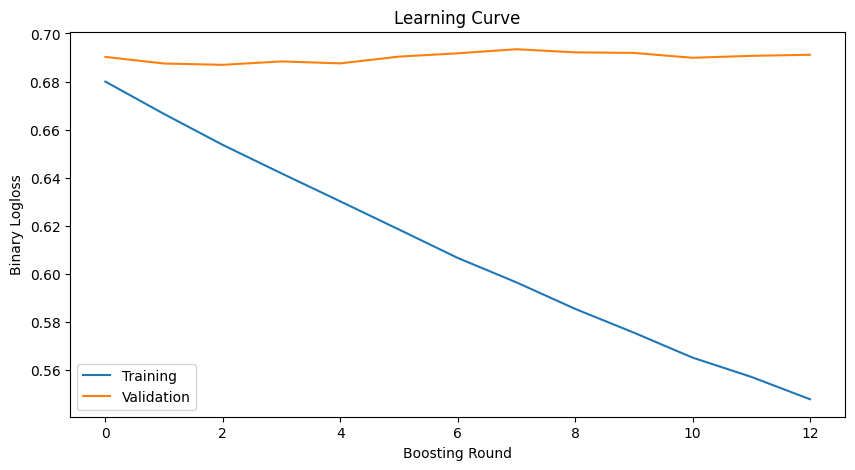

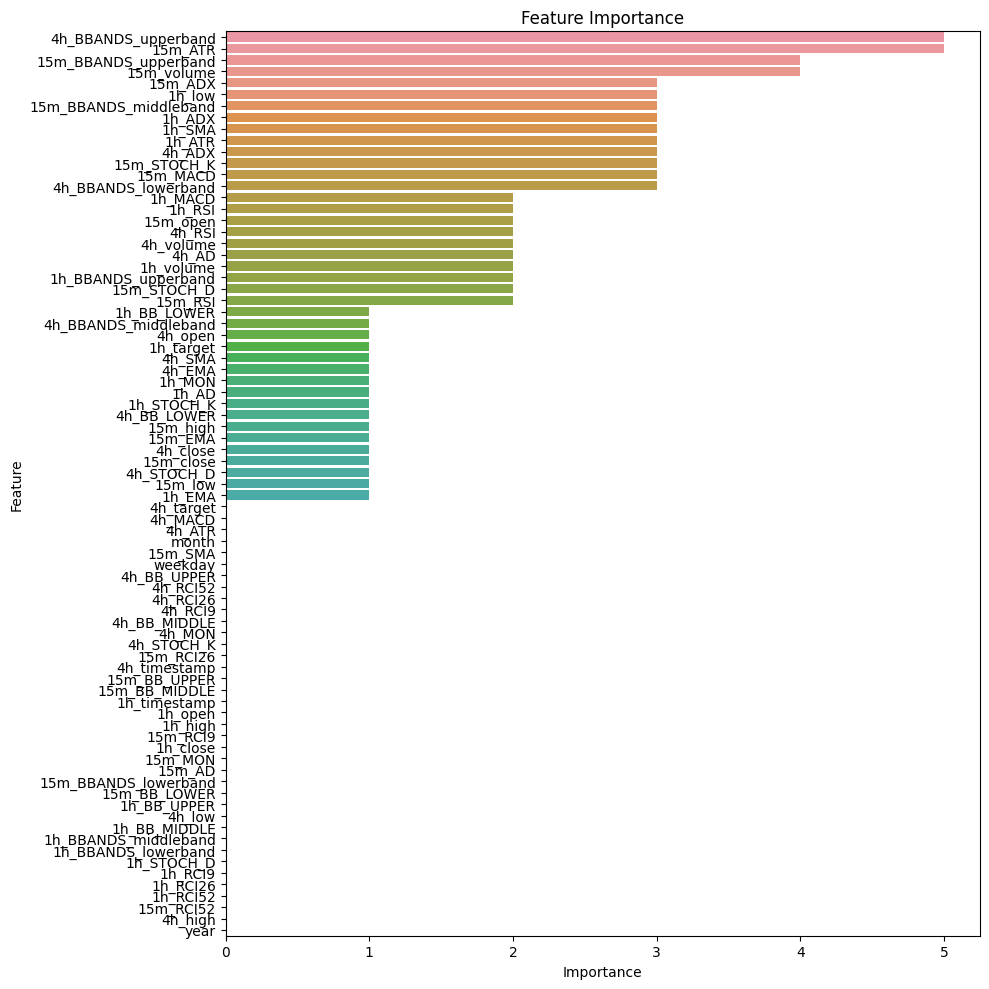

In [278]:
if __name__ == "__main__":
    file_names = [
        "data/BTCUSDT_15m_20210801_20211231.csv", 
        "data/BTCUSDT_1h_20210801_20211231.csv", 
        "data/BTCUSDT_4h_20210801_20211231.csv"]
    dfs = load_data(file_names)

    # 各タイムフレームのデータに対して特徴量エンジニアリングとラベル作成を行う
    processed_dfs = []
    for df in dfs:
        prefix = df.columns[0].split('_')[0]  # カラム名のプレフィックスを取得（例：15m）
        processed_df = feature_engineering(df, prefix)
        processed_df = create_label(processed_df, prefix)
        processed_dfs.append(processed_df)

    # 複数のタイムフレームのデータを結合（インデックスが一致するように注意）
    combined_df = pd.concat(processed_dfs, axis=1).dropna()
    display(combined_df)
    
    # さらに結合後に特徴量を追加する
    combined_df = add_features(combined_df)

    # モデルの学習と評価を行う
    model = train_and_evaluate(combined_df)
 
    # モデルを保存する
    model_path = os.path.join("model", "model.pkl")
    joblib.dump(model, model_path)